# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('/home/jovyan/data_preprocessing')

### Set file paths

In [ ]:
file_comments = "../../data/raw_data/PoliticalDebate_comments.zst"
file_submissions = "../../data/raw_data/PoliticalDebate_submissions.zst"

subreddit_here = "PoliticalDebate"

output_path = f"../../data/new_preprocessing/{subreddit_here}_new_preprocessing_com_rep.csv"


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time

pd.options.mode.chained_assignment = None

In [4]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import plot_submissions_comments
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [5]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [6]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [7]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

Nr. of pulled submissions 1381


In [8]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

Nr. of pulled comments & replies 93166


In [9]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

Nr. of comments 14787
Nr. of replies 12375


### Filter relevant submissions

* relevant_comments: those with a parent, that is in relevant_submissions

In [ ]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
print(relevant_submissions['count'].mean())
relevant_submissions


11.886655948553054


,submission_id,count
0,101cjul,3
1,1044y9i,3
2,1059una,5
3,105atyp,11
4,106qvgl,4
...,...,...
1239,ywutpc,3
1240,z08wcg,5
1241,z091gj,7
1242,zb07a0,3


In [12]:
plt_data = pd.DataFrame(relevant_submissions['count'].value_counts()).rename(columns={'count' : 'class_count'}).reset_index().rename(columns={'count' : 'comment_count'}).sort_values(by = "comment_count").reset_index(drop=True)

plt_data['log_com_count'] = plt_data['comment_count'].apply(lambda x: np.log10(x))
plt_data['log_class_count'] = plt_data['class_count'].apply(lambda x: np.log10(x))
plt_data

,comment_count,class_count,log_com_count,log_class_count
0,1,250,0.000000,2.397940
1,2,157,0.301030,2.195900
2,3,110,0.477121,2.041393
3,4,85,0.602060,1.929419
4,5,61,0.698970,1.785330
...,...,...,...,...
74,85,1,1.929419,0.000000
75,86,1,1.934498,0.000000
76,87,1,1.939519,0.000000
77,90,1,1.954243,0.000000


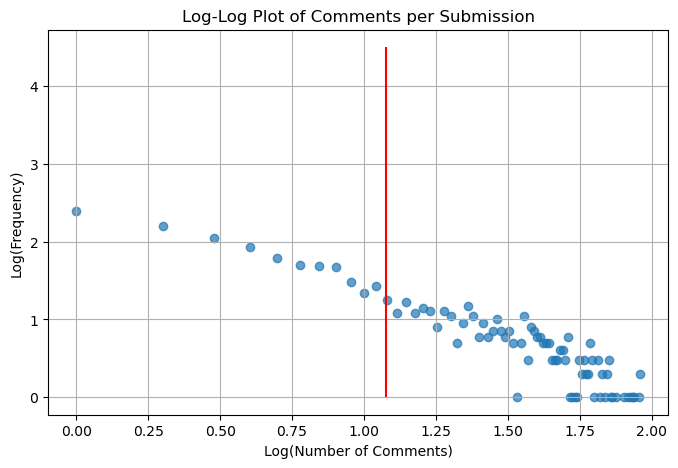

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(plt_data['log_com_count'], plt_data['log_class_count'], alpha=0.7)
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4.5)

plt.xlabel("Log(Number of Comments)")
plt.ylabel("Log(Frequency)")
plt.title("Log-Log Plot of Comments per Submission")
plt.grid(True)
plt.show()

In [16]:
# select relevant submissions

relevant_submissions, relevant_comments, empty_submissions, empty_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


Mean nr. of comments per submission 11.886655948553054
Nr. of submission, that I have comments for 1244
All submissions found
Removing empty submissions deleted 528 submissions
Empty submissions in df_submissions_empty: 528
Kept 716 submissions
Nr. of comments, whose submission is retaied 12750
Share 0.8622438628525055
Nr. of comments, whose submission is empty 2037
Share 0.13775613714749443


In [ ]:

print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

Number of relevant submissions: 716
Lost submissions:  665


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,[deleted],1.252976e+09,9kkf8,2r73k,I don't know if it's entirely manufactured but...,9kkf8,c0d5jwa,c0d5jwa,6.0,6,0.0,PoliticalDebate,NaN,NaN,NaN,NaN,NaN,2009-09-15,comment
1,jdoe2003,1.252978e+09,9kkf8,2r73k,I think most things in the media are manufactu...,9kkf8,c0d5m53,c0d5m53,3.0,3,0.0,PoliticalDebate,NaN,NaN,NaN,NaN,NaN,2009-09-15,comment
2,newliberty,1.252996e+09,9kncm,2r73k,For what it's worth - Glenn Beck has been insu...,9kncm,c0d5zrm,c0d5zrm,3.0,3,0.0,PoliticalDebate,NaN,NaN,NaN,NaN,NaN,2009-09-15,comment
3,bigstevec,1.253034e+09,9kkf8,2r73k,I don’t see it as a conspiracy on the left or ...,9kkf8,c0d6k0v,c0d6k0v,3.0,3,0.0,PoliticalDebate,NaN,NaN,NaN,NaN,NaN,2009-09-15,comment
4,[deleted],1.253053e+09,9kkf8,2r73k,You haven't seen the polling? Look at the perc...,9kkf8,c0d71cb,c0d71cb,-1.0,-1,0.0,PoliticalDebate,NaN,NaN,NaN,NaN,NaN,2009-09-15,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12745,RickySlayer9,1.704063e+09,18ut80y,2r73k,Simply by people A) expressing disinterest and...,18ut80y,kfreg6m,kfreg6m,1.0,1,0.0,PoliticalDebate,NaN,,False,True,NaN,2023-12-31,comment
12746,[deleted],1.704063e+09,18ut80y,2r73k,[removed],18ut80y,kfrg5x4,kfrg5x4,1.0,1,0.0,PoliticalDebate,NaN,,False,True,NaN,2023-12-31,comment
12747,Adezar,1.704066e+09,18vgjif,2r73k,I really wish children were protected from rel...,18vgjif,kfrlxy0,kfrlxy0,2.0,2,0.0,PoliticalDebate,NaN,,False,True,NaN,2023-12-31,comment
12748,CFSCFjr,1.704066e+09,18vgjif,2r73k,The state should absolutely be doing more to e...,18vgjif,kfrmjm6,kfrmjm6,9.0,9,0.0,PoliticalDebate,NaN,,False,True,NaN,2023-12-31,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [18]:
df_matched, com_per_sub, rep_per_com = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner', subreddit_here)
df_matched

Nr. of unique replies 10537
Nr. of unique comments 6337
Nr. of unique submissions 651
A submission receives on average 9.734254992319508 comments.
A comment receives on average 1.662774183367524 replies.
Share of matched submissions: 0.909217877094972


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0d5jwa,c0d5kfi,"I have a number of problems with Glenn Beck, b...",PoliticalDebate,1.252976e+09,tsoldrin,5.0,5,0.0,9kkf8,...,[deleted],6.0,6,0.0,1.252976e+09,Probably not how you think though.\n\nFirst......,tsoldrin,NaN,10,1.252974e+09
1,c0d5m53,c0d5vj9,I'm going to have to agree with you entirely. ...,PoliticalDebate,1.252990e+09,theawesomelucas,3.0,3,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though.\n\nFirst......,tsoldrin,NaN,10,1.252974e+09
2,c0d5m53,c0d6c7g,The problem is the nature of today's mass medi...,PoliticalDebate,1.253025e+09,gaijin777,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though.\n\nFirst......,tsoldrin,NaN,10,1.252974e+09
3,c0d5m53,c0d6jvc,"""Should have taken the blue pill.""\r\n\r\nFTFY",PoliticalDebate,1.253034e+09,bigstevec,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though.\n\nFirst......,tsoldrin,NaN,10,1.252974e+09
4,c0d71cb,c0d96jn,"please link to this poll, i am curious\n",PoliticalDebate,1.253177e+09,semarj,3.0,3,0.0,9kkf8,...,[deleted],-1.0,-1,0.0,1.253053e+09,Probably not how you think though.\n\nFirst......,tsoldrin,NaN,10,1.252974e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10532,kfp05ui,kfpuvgh,">^(Probably in a good libertarian society), **...",PoliticalDebate,1.704042e+09,RawLife53,1.0,1,0.0,18ut80y,...,jethomas5,2.0,2,0.0,1.704028e+09,So I’m fairly new to the Libertarian ideology ...,RocksLibertarianWood,10.0,10,1.703979e+09
10533,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,1.704063e+09,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,1.704022e+09,So I’m fairly new to the Libertarian ideology ...,RocksLibertarianWood,10.0,10,1.703979e+09
10534,kfrg5x4,kfrg5yp,Your comment was removed because you do not ha...,PoliticalDebate,1.704063e+09,AutoModerator,1.0,1,0.0,18ut80y,...,[deleted],1.0,1,0.0,1.704063e+09,So I’m fairly new to the Libertarian ideology ...,RocksLibertarianWood,10.0,10,1.703979e+09
10535,kfoqu1m,kfrgdfm,> *Libertarians tend to think we have enough t...,PoliticalDebate,1.704064e+09,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,1.704022e+09,So I’m fairly new to the Libertarian ideology ...,RocksLibertarianWood,10.0,10,1.703979e+09


In [20]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


In [ ]:
df_matched_empty, com_per_sub_empty, rep_per_com_empty = match_reply_comment_submission(replies, empty_comments, empty_submissions, 'inner', subreddit_here)
df_matched_empty

Nr. of unique replies 1274
Nr. of unique comments 903
Nr. of unique submissions 258
A submission receives on average 3.5 comments.
A comment receives on average 1.4108527131782946 replies.
Share of matched submissions: 0.48863636363636365


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0d5fxy,c0d5ggi,"Yeah, I hope so too. Right now it's mostly ab...",PoliticalDebate,1.252971e+09,[deleted],3.0,3,0.0,9kjmp,...,Gadsden,3.0,3,0.0,1.252970e+09,[deleted],[deleted],NaN,23,1.252968e+09
1,c0d5vto,c0d5vxy,Probably someone who's not into intelligent de...,PoliticalDebate,1.252990e+09,[deleted],2.0,2,0.0,9kjmp,...,theawesomelucas,6.0,6,0.0,1.252990e+09,[deleted],[deleted],NaN,23,1.252968e+09
2,c0d5vto,c0d6b9o,someone from the politics subreddit.,PoliticalDebate,1.253024e+09,HaveSomeVictoryGin,3.0,3,0.0,9kjmp,...,theawesomelucas,6.0,6,0.0,1.252990e+09,[deleted],[deleted],NaN,23,1.252968e+09
3,c0d5wrw,c0d5wz4,Excellent. This is exactly the type of commun...,PoliticalDebate,1.252992e+09,[deleted],2.0,2,0.0,9kjmp,...,kmeisthax,1.0,1,0.0,1.252992e+09,[deleted],[deleted],NaN,23,1.252968e+09
4,c0d6s3z,c0d6saj,"That's basically what I'm looking to do, is to...",PoliticalDebate,1.253043e+09,[deleted],1.0,1,0.0,9kjmp,...,orblivion,1.0,1,0.0,1.253043e+09,[deleted],[deleted],NaN,23,1.252968e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,kfq5zxq,kfq6bza,Do you not believe in free speech? Should you ...,PoliticalDebate,1.704046e+09,pinner52,-4.0,-4,0.0,18v7sh1,...,tigernike1,4.0,4,0.0,1.704046e+09,[removed],pinner52,1.0,1,1.704029e+09
1270,kfqd0dg,kfqfwol,A lot of comments I have received over the las...,PoliticalDebate,1.704050e+09,pinner52,1.0,1,0.0,18v7sh1,...,JellyfishQuiet7944,-2.0,-2,0.0,1.704049e+09,[removed],pinner52,1.0,1,1.704029e+09
1271,kfqi08a,kfqi0a3,Your comment was removed because you do not ha...,PoliticalDebate,1.704051e+09,AutoModerator,1.0,1,0.0,18v7sh1,...,[deleted],1.0,1,0.0,1.704051e+09,[removed],pinner52,1.0,1,1.704029e+09
1272,kfq4vml,kfqnqse,This is a very good post!,PoliticalDebate,1.704053e+09,PriceofObedience,1.0,1,0.0,18v7sh1,...,AnachronisticPenguin,6.0,6,0.0,1.704046e+09,[removed],pinner52,1.0,1,1.704029e+09


In [22]:

com_per_sub_empty = com_per_sub_empty.rename(columns={0 : 'nr_comments'})
rep_per_com_empty = rep_per_com_empty.rename(columns={0 : 'nr_replies'})

com_per_sub = com_per_sub.rename(columns={0 : 'nr_comments'})
rep_per_com = rep_per_com.rename(columns={0 : 'nr_replies'})


df_matched.to_csv(f"output/{subreddit_here}_df_matched.csv", index = False)
com_per_sub.to_csv(f"output/{subreddit_here}_com_per_sub.csv", index = False)
rep_per_com.to_csv(f"output/{subreddit_here}_rep_per_com.csv", index = False)

df_matched_empty.to_csv(f"output/{subreddit_here}_df_matched_empty.csv", index = False)
com_per_sub_empty.to_csv(f"output/{subreddit_here}_com_per_sub_empty.csv", index = False)
rep_per_com_empty.to_csv(f"output/{subreddit_here}_rep_per_com_empty.csv", index = False)

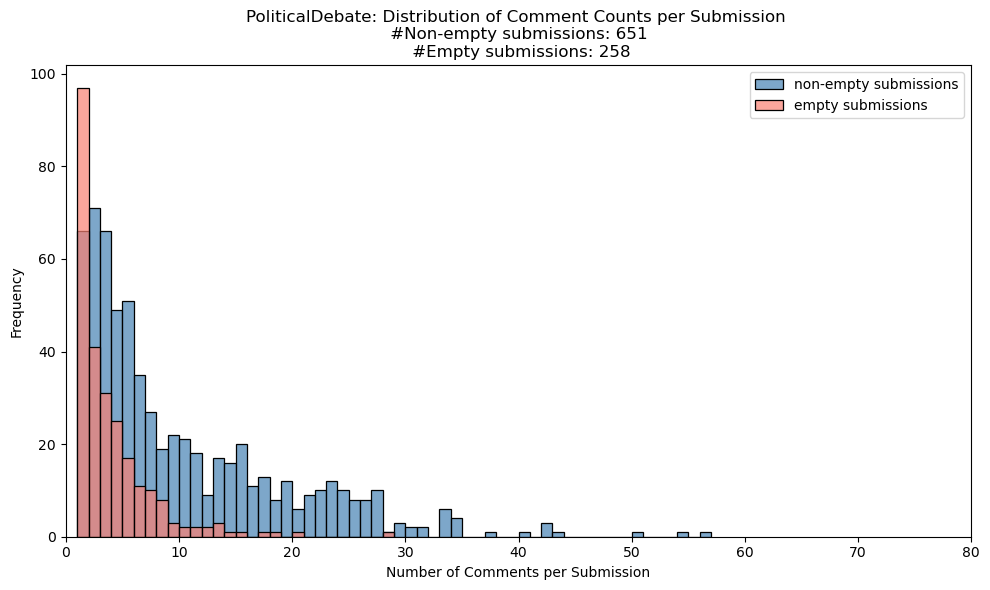

In [55]:
plt.figure(figsize=(10, 6))

sns.histplot(com_per_sub[0], binwidth=1, kde=False, label='non-empty submissions', color='steelblue', alpha=0.7)
sns.histplot(com_per_sub_empty[0], binwidth=1, kde=False, label='empty submissions', color='salmon', alpha=0.7)

plt.xlabel('Number of Comments per Submission')
plt.xlim(0, 80)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n #Non-empty submissions: {len(com_per_sub[0])} \n #Empty submissions: {len(com_per_sub_empty[0])}')
plt.legend()
plt.tight_layout()

plt.savefig(f"Hist_{subreddit_here}_Comments_per_Submission.pdf")
plt.show()


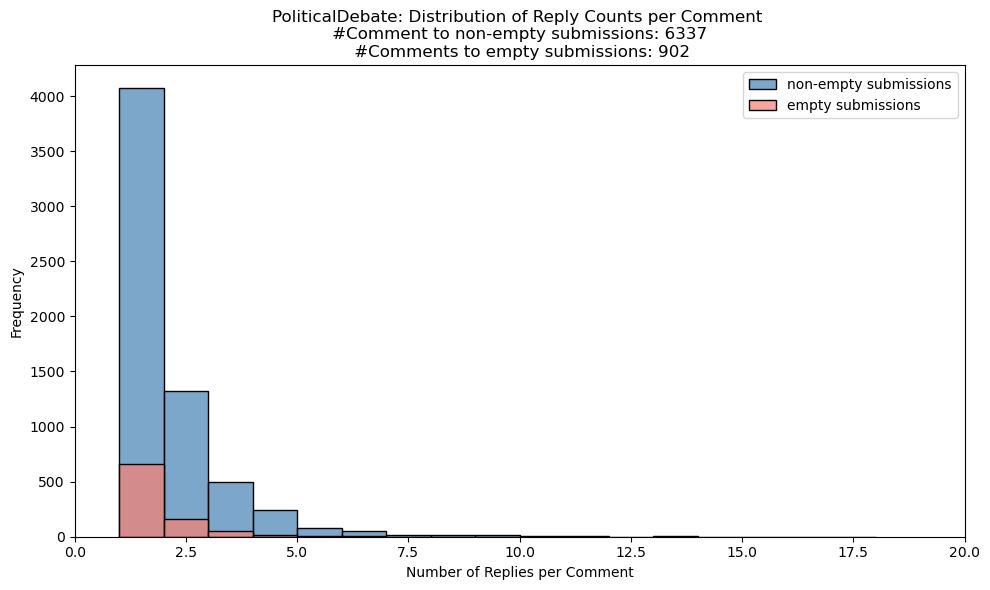

In [56]:
plt.figure(figsize=(10, 6))


sns.histplot(rep_per_com[0], binwidth=1, kde=False, label='non-empty submissions', color='steelblue', alpha=0.7)
sns.histplot(rep_per_com_empty[0], binwidth=1, kde=False, label='empty submissions', color='salmon', alpha=0.7)


plt.xlabel('Number of Replies per Comment')
plt.xlim(0, 20)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n #Comment to non-empty submissions: {len(rep_per_com[0])} \n #Comments to empty submissions: {len(rep_per_com_empty[0])}')
plt.legend()
plt.tight_layout()
plt.savefig(f"Hist_{subreddit_here}_Replies_per_Comment.pdf")
plt.show()


C:\Users\3leso\AppData\Local\Temp\ipykernel_6804\1162474450.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])


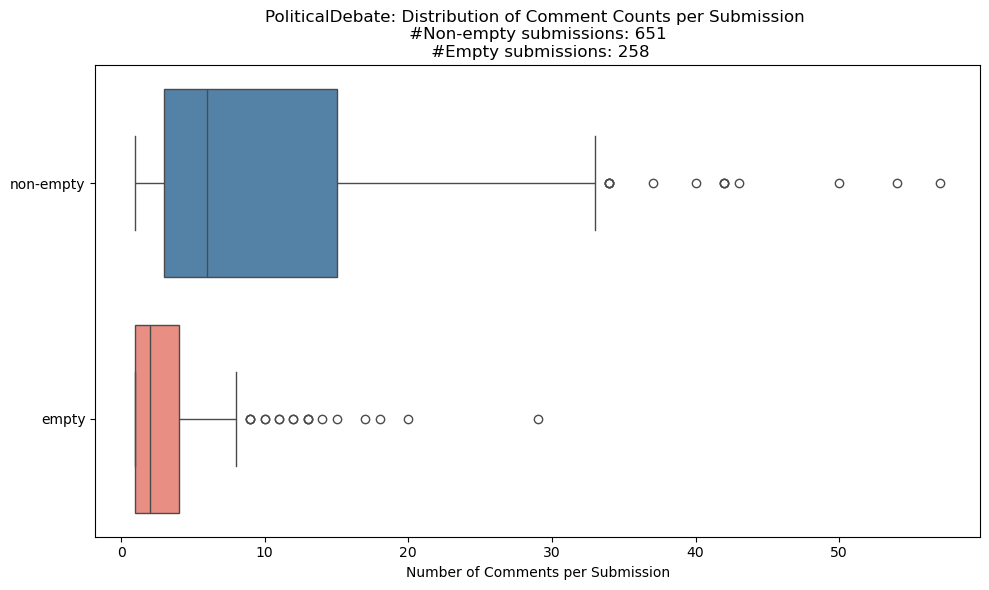

In [57]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([com_per_sub[0], com_per_sub_empty[0]], ignore_index=True),
    'type': ['non-empty'] * len(com_per_sub[0]) + ['empty'] * len(com_per_sub_empty[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Comments per Submission')
plt.ylabel('')
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n #Non-empty submissions: {len(com_per_sub[0])} \n #Empty submissions: {len(com_per_sub_empty[0])}')
plt.savefig(f"Box_{subreddit_here}_Comments_per_Submission.pdf")

plt.tight_layout()
plt.show()

C:\Users\3leso\AppData\Local\Temp\ipykernel_6804\2145357384.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])


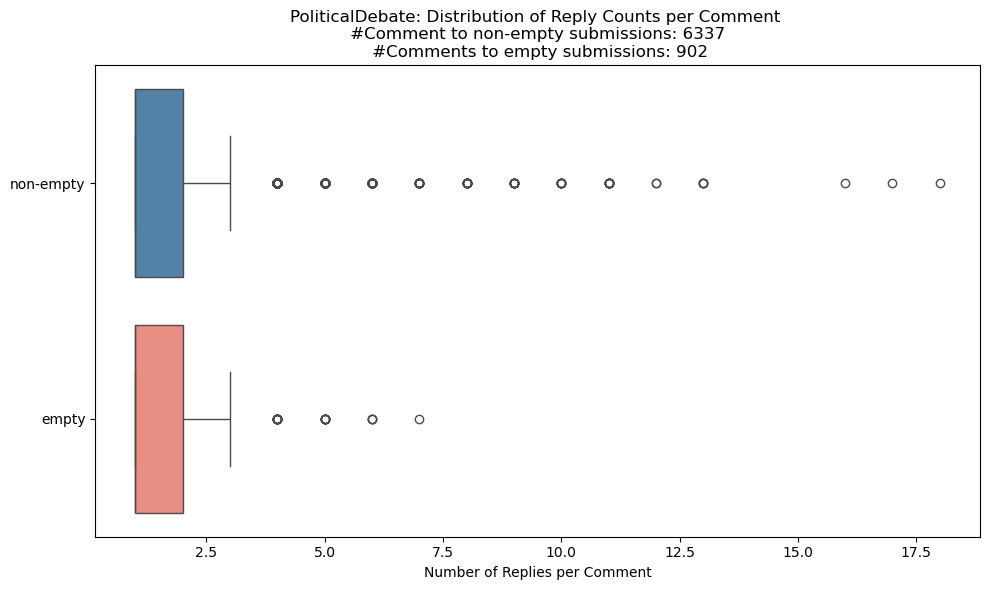

In [58]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([rep_per_com[0], rep_per_com_empty[0]], ignore_index=True),
    'type': ['non-empty'] * len(rep_per_com[0]) + ['empty'] * len(rep_per_com_empty[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Replies per Comment')
plt.ylabel('')
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n #Comment to non-empty submissions: {len(rep_per_com[0])} \n #Comments to empty submissions: {len(rep_per_com_empty[0])}')
plt.savefig(f"Box_{subreddit_here}_Replies_per_Comment.pdf")

plt.tight_layout()
plt.show()

In [20]:
print(com_per_sub[0].describe())
print(com_per_sub_empty[0].describe())

count    651.000000
mean       9.734255
std        9.152976
min        1.000000
25%        3.000000
50%        6.000000
75%       15.000000
max       57.000000
Name: 0, dtype: float64
count    258.000000
mean       3.496124
std        3.618207
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       29.000000
Name: 0, dtype: float64


In [21]:
print(rep_per_com[0].describe())
print(rep_per_com_empty[0].describe())

count    6337.000000
mean        1.662774
std         1.288813
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        18.000000
Name: 0, dtype: float64
count    902.000000
mean       1.412417
std        0.827242
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: 0, dtype: float64



### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [22]:
df_matched['body_child'].value_counts().head(10)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

body_child
Your comment was removed because you do not have a user flair. We require members to have a user flair to participate on this sub.\nFor instructions on how to add a user flair [click here](https://support.reddithelp.com/hc/en-us/articles/205242695-How-do-I-get-user-flair-#:~:text=On%20reddit.com,set%20it%20up%20for%20you) \n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/PoliticalDebate) if you have any questions or concerns.*    580
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [23]:
df = preprocess_texts(data = df_matched, length = 5)
df

Deleting all interactions with empty texts removed 392 interactions. Share:  0.037202239726677425
Kept 10145 interactions.
Deleting empty authors deleted 131 interactions. Share:  0.01291276490882208
Kept 10014 interactions.
Length 5 removes 696 interactions
Kept 9318 interactions
Drop duplicates (in parent & child text and author) removed 3 interactions. Share:  0.0003219575016097875
Kept 9315 interactions.
After text cleaning 3 interactions had empty texts and got removed. Share:  0.00032206119162640903
Kept 9312 interactions.


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0d5m53,c0d5vj9,I'm going to have to agree with you entirely. ...,PoliticalDebate,1.252990e+09,theawesomelucas,3.0,3,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
1,c0d5m53,c0d6c7g,The problem is the nature of today's mass medi...,PoliticalDebate,1.253025e+09,gaijin777,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
2,c0d5m53,c0d6jvc,Should have taken the blue pill.\r \r FTFY,PoliticalDebate,1.253034e+09,bigstevec,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
3,c0d5zrm,c0d7f4g,I backed up Glenn Beck as long as I could but ...,PoliticalDebate,1.253072e+09,orblivion,1.0,1,0.0,9kncm,...,newliberty,3.0,3,0.0,1.252996e+09,Groupthink is a type of thought process in whi...,kmeisthax,NaN,7,1.252993e+09
4,c7fp9wr,c7fpb3l,I seem to notice that as well. It said the nam...,PoliticalDebate,1.355362e+09,ChurroMooCow,1.0,1,0.0,14r5kt,...,Trayf,2.0,2,0.0,1.355362e+09,Hi guys! I would like to proudly announce that...,ChurroMooCow,2.0,2,1.355356e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9307,kfmqpen,kfr2jzu,Anyone caught fabricating or withholding evide...,PoliticalDebate,1.704058e+09,Old_Letterhead6471,1.0,1,0.0,18uokq0,...,Daemonic_One,2.0,2,0.0,1.703983e+09,In theory I dont object to the concept that ce...,CFSCFjr,25.0,25,1.703967e+09
9308,kfnu3qb,kfrb9ca,"Genuine question as a potential trump voter, a...",PoliticalDebate,1.704061e+09,CryAffectionate7334,1.0,1,0.0,18upkh1,...,andromeda880,4.0,4,0.0,1.704000e+09,I hope I didn't word that too confusingly. Bas...,DivideEtImpala,1.0,1,1.703970e+09
9309,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,1.704063e+09,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09
9310,kfoqu1m,kfrgdfm,Libertarians tend to think we have enough tim...,PoliticalDebate,1.704064e+09,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09


In [24]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


## **Check for Mods**

In [25]:
df['author_submission'].value_counts()[:20]

author_submission
Usernameofthisuser    917
RawLife53             337
JanFromEarth          286
theabyssaboveyou      234
NoBetterFriend1231    202
CFSCFjr               194
TheMagicJankster      189
Ted928                172
The_Grizzly-          159
youtellmebob          148
RadioRavenRide        148
shadow_nipple         147
pinner52              146
Prevatteism           127
GeneJock85            120
MSGRiley              116
Salem1690s            115
GitmoGrrl1            109
chemprof4real          97
jethomas5              97
Name: count, dtype: int64

In [26]:
df['author_parent'].value_counts()[:20]

author_parent
TuvixWasMurderedR1P    112
Usernameofthisuser      99
MSGRiley                98
rdinsb                  94
Prevatteism             94
GeneJock85              94
BlueCollarRevolt        87
Daily_the_Project21     74
JanFromEarth            74
chemprof4real           67
Kman17                  66
PriceofObedience        63
marxianthings           57
FaustusC                48
RawLife53               48
Player7592              47
Gardener_Of_Eden        46
I405CA                  45
4_Legged_Duck           44
pakidara                43
Name: count, dtype: int64

In [27]:
df['author_child'].value_counts()[:20]

author_child
AutoModerator              567
Usernameofthisuser         398
MSGRiley                   151
CFSCFjr                    148
GeneJock85                 136
Ted928                     134
NoBetterFriend1231         109
dedicated-pedestrian       100
JanFromEarth                98
RawLife53                   94
TheMagicJankster            88
rdinsb                      86
theabyssaboveyou            81
DebonairDeistagain          80
Prevatteism                 76
NotmyRealNameJohn           73
PoliticalDebate-ModTeam     73
shadow_nipple               73
youtellmebob                65
chemprof4real               61
Name: count, dtype: int64

In [29]:
df[df['author_child'] == 'AutoModerator'].drop_duplicates(subset="msg_id_child")

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
2533,k7gxi0a,k7gxi13,Your comment was removed because you do not ha...,PoliticalDebate,1.698902e+09,AutoModerator,1.0,1,0.0,17ipehu,...,Comfortable-Wrap-723,1.0,1,0.0,1.698902e+09,"Begining to learn about communism in China, I'...",Usernameofthisuser,1.0,1,1.698534e+09
2535,k7h6a3x,k7h6a4j,Your comment was removed because you do not ha...,PoliticalDebate,1.698908e+09,AutoModerator,2.0,2,0.0,17log7v,...,jaxnmarko,2.0,2,0.0,1.698908e+09,"Had the day off today, and decided to piss awa...",NoBetterFriend1231,6.0,6,1.698878e+09
2539,k7i8syz,k7i8t0e,Your comment was removed because you do not ha...,PoliticalDebate,1.698933e+09,AutoModerator,1.0,1,0.0,17lgah8,...,Vegasgiants,1.0,1,0.0,1.698933e+09,How do people feel about dual citizens holding...,FaustusC,4.0,4,1.698857e+09
2552,k7iqhxn,k7iqhzf,Your comment was removed because you do not ha...,PoliticalDebate,1.698940e+09,AutoModerator,1.0,1,0.0,17log7v,...,NikD4866,1.0,1,0.0,1.698940e+09,"Had the day off today, and decided to piss awa...",NoBetterFriend1231,6.0,6,1.698878e+09
2599,k7lf32v,k7lf345,Your comment was removed because you do not ha...,PoliticalDebate,1.698976e+09,AutoModerator,1.0,1,0.0,17kx718,...,Agreeable_Seat_8545,1.0,1,0.0,1.698976e+09,One of the cool things about having a start up...,Usernameofthisuser,1.0,1,1.698791e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8246,kep95os,kep95q4,Your comment was removed because you do not ha...,PoliticalDebate,1.703391e+09,AutoModerator,1.0,1,0.0,18picwe,...,decidious_underscore,1.0,1,0.0,1.703391e+09,The solution to the issue of immigration is do...,HeathrJarrod,1.0,1,1.703375e+09
8335,kevhkof,kevhkq4,Your comment was removed because you do not ha...,PoliticalDebate,1.703521e+09,AutoModerator,1.0,1,0.0,18q9i8z,...,HaphazardFlitBipper,2.0,2,0.0,1.703521e+09,We've seen states put a ban on use of some pla...,RawLife53,5.0,5,1.703471e+09
8354,kew3thj,kew3tiu,Your comment was removed because you do not ha...,PoliticalDebate,1.703531e+09,AutoModerator,1.0,1,0.0,18qeeuy,...,Honest-qs,1.0,1,0.0,1.703531e+09,The term virtue signaling is the act of expres...,The_Grizzly-,12.0,12,1.703492e+09
8792,kfa36f9,kfa36hu,Your comment was removed because you do not ha...,PoliticalDebate,1.703779e+09,AutoModerator,1.0,1,0.0,18sr87d,...,Luvata-8,1.0,1,0.0,1.703779e+09,Shes moving to a district CD4 that leans 27 po...,NorthChiller,6.0,6,1.703761e+09


In [30]:

print("Child", len(df[df['author_child'] == 'AutoModerator'].drop_duplicates(subset="msg_id_child")))
print("Parent", len(df[df['author_parent'] == 'AutoModerator'].drop_duplicates(subset="msg_id_parent")))
print("Submission", len(df[df['author_submission'] == 'AutoModerator'].drop_duplicates(subset="submission_id")))

len(df)

Child 567
Parent 4
Submission 4


9312

In [31]:
df[df['author_child'] == "AutoModerator"]['body_child'].value_counts()

body_child
Your comment was removed because you do not have a user flair. We require members to have a user flair to participate on this sub. For instructions on how to add a user flair click here I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.                                                                                                                         545
Your comment was removed for being uncivilized, which breaks our rules. We encourage you to repost your comment in a more civilized manner. I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.                                                                                                                                                                        16
Your post has been removed due to the use of mu

In [32]:
df[df['author_parent'] == 'AutoModerator']['body_parent'].value_counts()

body_parent
 Reminder that this sub is for civilized discussion. No name calling or insults will be tolerated. If you're a new member you need a user flair to participate, so flair up! I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.    3
Reminder that this sub is for civilized discussion. No name calling or insults will be tolerated. If you're a new member you need a user flair to participate, so flair up! I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.     1
Name: count, dtype: int64

In [33]:
df[df['author_submission'] == 'AutoModerator']['submission_text'].value_counts()

submission_text
This thread serves as a way to ease off the stress and anger that goes along with these political debates. Talk about anything and everything. Book clubs, TV, current events, sports, personal lives, study groups, etc. Our rules are still enforced, remain civilized. Also I'm once again asking you to report any uncivilized behavior. Help us mods keep the subs standard of discourse high and don't let anything slip between the cracks.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [34]:
df_no_mod = df[df['author_child'] != 'AutoModerator'].reset_index(drop = True)
df_no_mod = df_no_mod[df_no_mod['author_parent'] != 'AutoModerator'].reset_index(drop = True)
#df_no_mod = df_no_mod[df_no_mod['author_submission'] != 'AutoModerator'].reset_index(drop = True)

print(len(df) - len(df_no_mod))

df_no_mod

571


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0d5m53,c0d5vj9,I'm going to have to agree with you entirely. ...,PoliticalDebate,1.252990e+09,theawesomelucas,3.0,3,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
1,c0d5m53,c0d6c7g,The problem is the nature of today's mass medi...,PoliticalDebate,1.253025e+09,gaijin777,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
2,c0d5m53,c0d6jvc,Should have taken the blue pill.\r \r FTFY,PoliticalDebate,1.253034e+09,bigstevec,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
3,c0d5zrm,c0d7f4g,I backed up Glenn Beck as long as I could but ...,PoliticalDebate,1.253072e+09,orblivion,1.0,1,0.0,9kncm,...,newliberty,3.0,3,0.0,1.252996e+09,Groupthink is a type of thought process in whi...,kmeisthax,NaN,7,1.252993e+09
4,c7fp9wr,c7fpb3l,I seem to notice that as well. It said the nam...,PoliticalDebate,1.355362e+09,ChurroMooCow,1.0,1,0.0,14r5kt,...,Trayf,2.0,2,0.0,1.355362e+09,Hi guys! I would like to proudly announce that...,ChurroMooCow,2.0,2,1.355356e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8736,kfmqpen,kfr2jzu,Anyone caught fabricating or withholding evide...,PoliticalDebate,1.704058e+09,Old_Letterhead6471,1.0,1,0.0,18uokq0,...,Daemonic_One,2.0,2,0.0,1.703983e+09,In theory I dont object to the concept that ce...,CFSCFjr,25.0,25,1.703967e+09
8737,kfnu3qb,kfrb9ca,"Genuine question as a potential trump voter, a...",PoliticalDebate,1.704061e+09,CryAffectionate7334,1.0,1,0.0,18upkh1,...,andromeda880,4.0,4,0.0,1.704000e+09,I hope I didn't word that too confusingly. Bas...,DivideEtImpala,1.0,1,1.703970e+09
8738,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,1.704063e+09,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09
8739,kfoqu1m,kfrgdfm,Libertarians tend to think we have enough tim...,PoliticalDebate,1.704064e+09,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09


In [35]:
print(len(df_no_mod))


mod_submissions = df_no_mod[df_no_mod['author_submission'] == "AutoModerator"].reset_index(drop = True)
no_mod_submissions = df_no_mod[df_no_mod['author_submission'] != "AutoModerator"].reset_index(drop = True)
print(len(mod_submissions) + len(no_mod_submissions))

8741
8741


In [37]:
mod_submissions.drop_duplicates(subset="submission_id")

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,k81ge8b,k82q6t2,Yeah this got me when talking about the imf,PoliticalDebate,1.699283e+09,starswtt,1.0,1,0.0,17ow87y,...,hardmantown,4.0,4,0.0,1.699253e+09,Things can get pretty heated or stressful in p...,AutoModerator,4.0,4,1.699251e+09
2,k92mksz,k92zl6p,The two-time Green Party nominee said she woul...,PoliticalDebate,1.699892e+09,Difrntthoughtpatrn,2.0,2,0.0,17u4az6,...,kjvlv,1.0,1,0.0,1.699887e+09,This thread serves as a way to ease off the st...,AutoModerator,4.0,4,1.699855e+09
7,k9zkhjw,k9zkrqr,I used to read manga when I was little. Was co...,PoliticalDebate,1.700461e+09,Usernameofthisuser,2.0,2,0.0,17zhtwx,...,RadioRavenRide,3.0,3,0.0,1.700461e+09,This thread serves as a way to ease off the st...,AutoModerator,4.0,4,1.700460e+09
14,kay8sq0,kayi17h,And you would consider questioning how much wa...,PoliticalDebate,1.701080e+09,Maveko_YuriLover,3.0,3,0.0,184w2ja,...,TheMagicJankster,-3.0,-3,0.0,1.701073e+09,This thread serves as a way to ease off the st...,AutoModerator,4.0,4,1.701065e+09


In [38]:

def get_discussion_structure(df):

    unique_comments = df[['submission_id', 'msg_id_parent']].drop_duplicates()
    com_per_sub = pd.DataFrame(unique_comments.groupby('submission_id').size()).reset_index()
    mean_comments = com_per_sub[0].mean()

    unique_replies = df[['msg_id_parent', 'msg_id_child']].drop_duplicates()
    rep_per_com = pd.DataFrame(unique_replies.groupby('msg_id_parent').size()).reset_index()
    mean_replies = rep_per_com[0].mean()

    print("A submission receives on average", mean_comments, "comments.")
    print("A comment receives on average", mean_replies, "replies.")
    
    return com_per_sub, rep_per_com

mod_com_per_sub, mod_rep_per_com = get_discussion_structure(mod_submissions)

A submission receives on average 4.0 comments.
A comment receives on average 1.8125 replies.


In [39]:
no_mod_com_per_sub, no_mod_rep_per_com = get_discussion_structure(no_mod_submissions)

A submission receives on average 8.630048465266558 comments.
A comment receives on average 1.6308498689629352 replies.


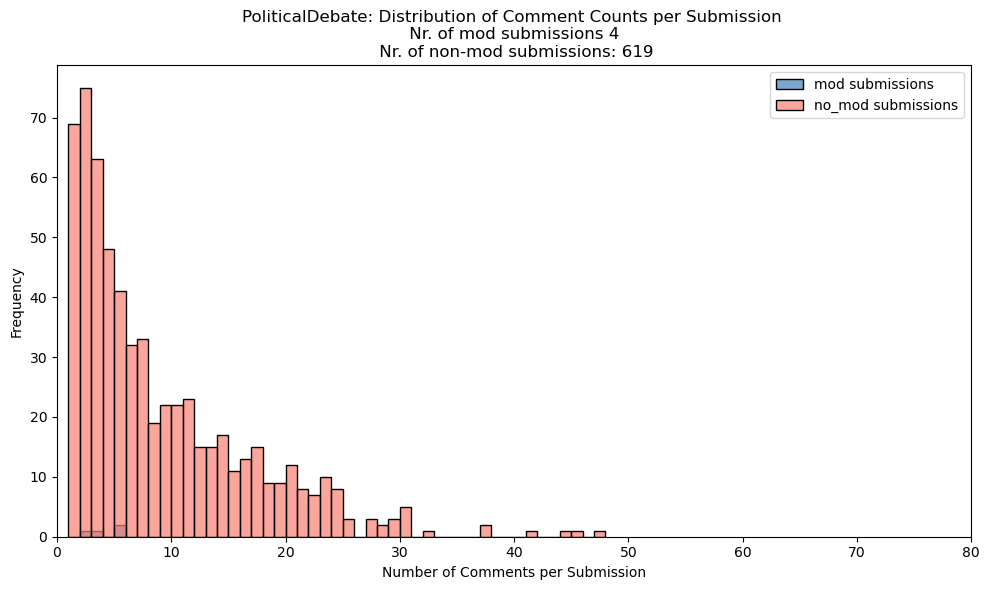

In [59]:
plt.figure(figsize=(10, 6))

sns.histplot(mod_com_per_sub[0], binwidth=1, kde=False, label='mod submissions', color='steelblue', alpha=0.7)
sns.histplot(no_mod_com_per_sub[0], binwidth=1, kde=False, label='no_mod submissions', color='salmon', alpha=0.7)

plt.xlabel('Number of Comments per Submission')
plt.xlim(0, 80)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n Nr. of mod submissions {len(mod_com_per_sub[0])} \n Nr. of non-mod submissions: {len(no_mod_com_per_sub[0])}')
plt.legend()
plt.tight_layout()

plt.savefig(f"Mod_Hist_{subreddit_here}_Comments_per_Submission.pdf")
plt.show()


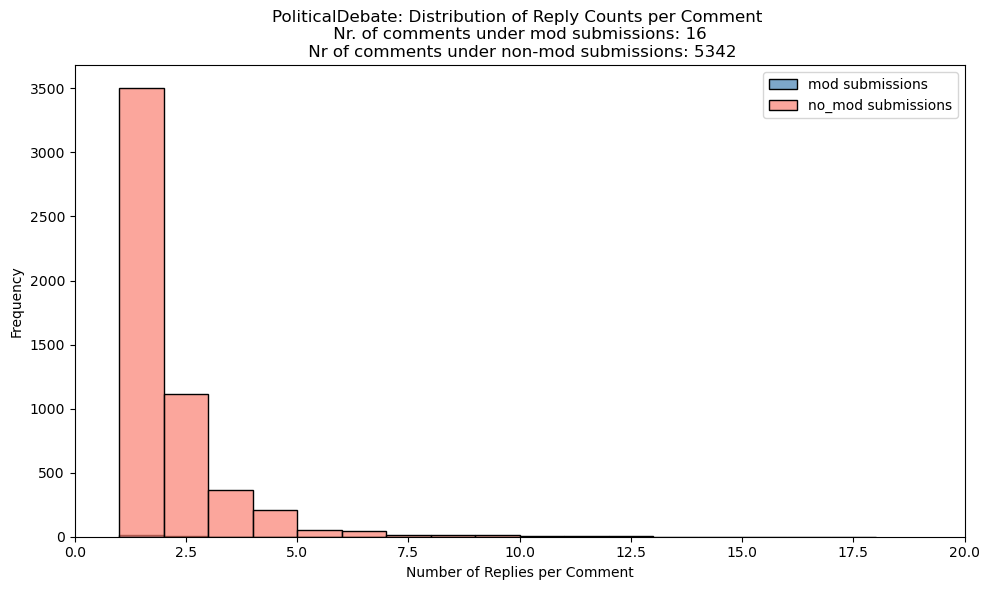

In [60]:
plt.figure(figsize=(10, 6))


sns.histplot(mod_rep_per_com[0], binwidth=1, kde=False, label='mod submissions', color='steelblue', alpha=0.7)
sns.histplot(no_mod_rep_per_com[0], binwidth=1, kde=False, label='no_mod submissions', color='salmon', alpha=0.7)


plt.xlabel('Number of Replies per Comment')
plt.xlim(0, 20)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n Nr. of comments under mod submissions: {len(mod_rep_per_com[0])} \n Nr of comments under non-mod submissions: {len(no_mod_rep_per_com[0])}')
plt.legend()
plt.tight_layout()
plt.savefig(f"Mod_Hist_{subreddit_here}_Replies_per_Comment.pdf")
plt.show()


C:\Users\3leso\AppData\Local\Temp\ipykernel_6804\2053345917.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


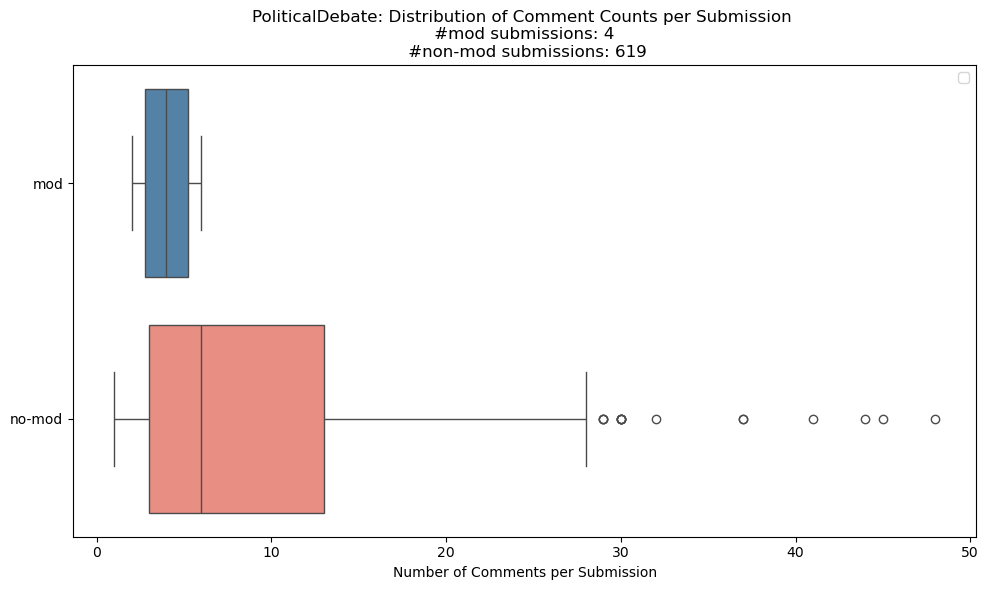

In [61]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([mod_com_per_sub[0], no_mod_com_per_sub[0]], ignore_index=True),
    'type': ['mod'] * len(mod_com_per_sub[0]) + ['no-mod'] * len(no_mod_com_per_sub[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Comments per Submission')
plt.ylabel('')
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n #mod submissions: {len(mod_com_per_sub[0])} \n #non-mod submissions: {len(no_mod_com_per_sub[0])}')
plt.savefig(f"Mod_Box_{subreddit_here}_Comments_per_Submission.pdf")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\3leso\AppData\Local\Temp\ipykernel_6804\1890821540.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])


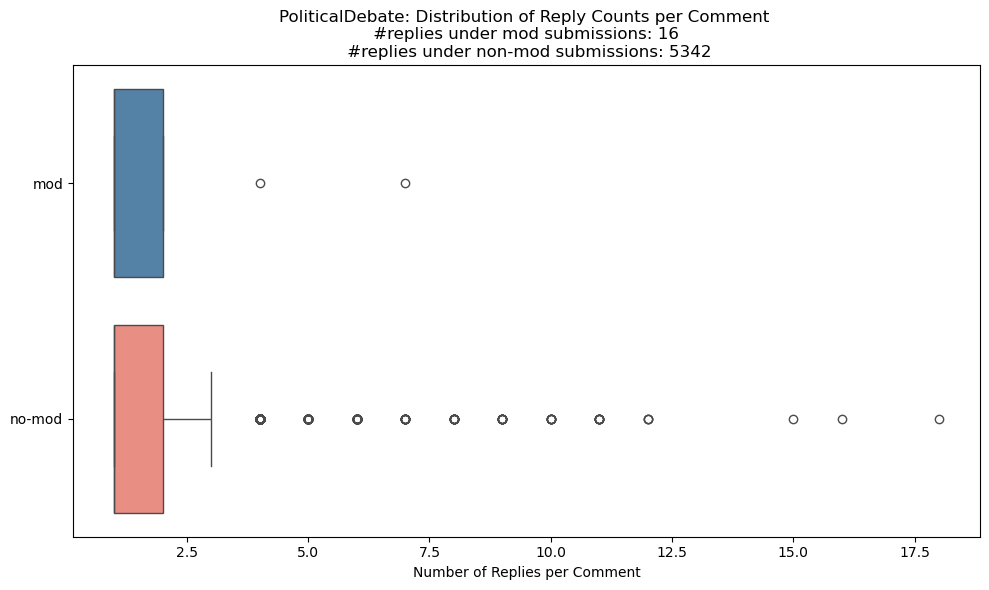

In [62]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([mod_rep_per_com[0], no_mod_rep_per_com[0]], ignore_index=True),
    'type': ['mod'] * len(mod_rep_per_com[0]) + ['no-mod'] * len(no_mod_rep_per_com[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Replies per Comment')
plt.ylabel('')
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n #replies under mod submissions: {len(mod_rep_per_com[0])} \n #replies under non-mod submissions: {len(no_mod_rep_per_com[0])}')
plt.savefig(f"Mod_Box_{subreddit_here}_Replies_per_Comment.pdf")

plt.tight_layout()
plt.show()



### Save and export

In [ ]:
df_no_mod.to_csv(output_path, index = False)
df_no_mod = pd.read_csv(output_path)
df_no_mod

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0d5m53,c0d5vj9,I'm going to have to agree with you entirely. ...,PoliticalDebate,1.252990e+09,theawesomelucas,3.0,3,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
1,c0d5m53,c0d6c7g,The problem is the nature of today's mass medi...,PoliticalDebate,1.253025e+09,gaijin777,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
2,c0d5m53,c0d6jvc,Should have taken the blue pill.\r \r FTFY,PoliticalDebate,1.253034e+09,bigstevec,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
3,c0d5zrm,c0d7f4g,I backed up Glenn Beck as long as I could but ...,PoliticalDebate,1.253072e+09,orblivion,1.0,1,0.0,9kncm,...,newliberty,3.0,3,0.0,1.252996e+09,Groupthink is a type of thought process in whi...,kmeisthax,NaN,7,1.252993e+09
4,c7fp9wr,c7fpb3l,I seem to notice that as well. It said the nam...,PoliticalDebate,1.355362e+09,ChurroMooCow,1.0,1,0.0,14r5kt,...,Trayf,2.0,2,0.0,1.355362e+09,Hi guys! I would like to proudly announce that...,ChurroMooCow,2.0,2,1.355356e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8736,kfmqpen,kfr2jzu,Anyone caught fabricating or withholding evide...,PoliticalDebate,1.704058e+09,Old_Letterhead6471,1.0,1,0.0,18uokq0,...,Daemonic_One,2.0,2,0.0,1.703983e+09,In theory I dont object to the concept that ce...,CFSCFjr,25.0,25,1.703967e+09
8737,kfnu3qb,kfrb9ca,"Genuine question as a potential trump voter, a...",PoliticalDebate,1.704061e+09,CryAffectionate7334,1.0,1,0.0,18upkh1,...,andromeda880,4.0,4,0.0,1.704000e+09,I hope I didn't word that too confusingly. Bas...,DivideEtImpala,1.0,1,1.703970e+09
8738,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,1.704063e+09,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09
8739,kfoqu1m,kfrgdfm,Libertarians tend to think we have enough tim...,PoliticalDebate,1.704064e+09,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09


***
## **Descriptive Stats**

In [90]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

4151
Unique Users:  3727


### Time Stats and originally pulled counts

In [ ]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2009-09-15
End of time frame: 2024-01-01
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 1381
Number of comments and replies: 93166
---------------------------------------------



### Descriptive Stats after Matching

In [92]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  10537
Number of unique comments:  6337
Number of unique submissions:  651


### Descriptive Stats after cleaning for high quality texts

In [93]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  9312
Unique Comments:  5761
Unique Submissions:  623


In [94]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  2449


### No Mods df

In [96]:
print("Unique Replies: ", len(df_no_mod['msg_id_child'].unique()))
print("Unique Comments: ", len(df_no_mod['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df_no_mod['submission_id'].unique()))

Unique Replies:  8741
Unique Comments:  5358
Unique Submissions:  623


In [97]:
print("Unique Users: ", len(set(df_no_mod['author_child']).union(df_no_mod['author_parent'], df_no_mod['author_submission'])))

Unique Users:  2291
